# Cash Transfer Experiement
We use the cash transfer dataset (Angelucci and Giorgi, 2009) to illustrate the statistical bound in our paper. The data comes from a study of the impact of Progresa, a social program in Mexico that gives cash gifts to low income households. Although, the effects on the population receiving the cash transfers is important, Angelucci and Giorgi argue that we must also analyze the impact on the remaining members of the village that are not eligible in order to understandardized the full impact of the program.  However, due to concerns that the non-poor households might have a large influence, the authors decided to limit the range of consumption outcomes for these households (less than 10,000). This results in robustness in the analysis for the poor household but sensitive results for the non-poor households. For our analysis we will  only use data from time period 8. After removing all entries with no response variable (household consumption), we used the remaining $n = 53552$ datapoints. 

### Notation
For our analysis we use the following notation:

$z=(x,y)$

$\ell(z,\theta)= (y - x^T\theta) + \lambda \theta^T \theta$ is the loss function

$H_\star = \nabla_{\theta_\star}^2 \ell (\theta_\star)$ is the population Hessian

$H_n(\theta_n) := \frac{1}{n} \sum_{i=1}^n \nabla_{\theta_n}^2 \ell(z_i, \theta_n)$ is the estimate of the Hessian

$\theta_n$ is calculated using ridge regression


In [2]:
# Download Data
import pandas as pd
import numpy as np
from utils import cash_transfer_data, if_diff_n_cash, clean_results_cash, bound_values_cash
import warnings
warnings.filterwarnings('ignore')


standardized_data = cash_transfer_data(
    "../data/cash_transfer_data/table1.dta")


# Empirical Influence Function for Ridge Regression
We will use the following closed form solution for the empirical influence function provided by Cook and Weisberg (1982).

$I_n(z)= -H_n(\theta_n)^{-1}\nabla \ell(z,\theta_n)$

We define the following:

$H_n(\theta_n) = \frac1n \sum_{i=1}^n x_ix_i^T + \lambda_I$ 

$\nabla \ell(z,\theta_n) = -(y-x^T\theta_n)x + \lambda\theta_n$

$\theta_n$ is calculated using ridge regression

In [7]:
# Finding theta values using Ridge regression
def ridge(x, y, lambda_):
    hess = np.matmul(x.T, x) + lambda_ * np.eye(x.shape[1])
    grad = np.matmul(x.T, y)
    return np.linalg.solve(hess, grad)

# Empirical Influence Function for Linear Regression
def emp_if_lin(x_sim, y_sim, x_con, y_con, lambda_, n):
    theta_n = ridge(x_sim, y_sim, lambda_)
    hess = np.matmul(x_sim.T, x_sim) / n + lambda_ * np.eye(x_sim.shape[1])
    grad = (np.dot(x_con, theta_n) - y_con).item() * \
        x_con + np.sum(lambda_*theta_n)
    return -np.linalg.solve(hess, np.transpose(grad)), hess


## Run Experiements
We now calculate the difference between the empirical influence and population influence of $100$ training datapoint using different sub-samples of the dataset ($n = 49, 201, 814, 3287, 13268$). We consider the influence calcuated using the whole dataset ($n=53552$) as the poulation. We use $\lambda_1 = 0.01$. 


In [8]:
# Run Simulation
time = 8
n_sim = 100
lambda_ = .01
results_tot, n_ls, H_pop = if_diff_n_cash(
    standardized_data, time, n_sim, lambda_, emp_if_lin)

# Clean Results
mean_diff_abs_total, sd_diff_abs_total = clean_results_cash(
    n_ls, results_tot, H_pop)


## Calculate Statistical Bound (Theorem 1)
We calculate the bound from Theorem 1 without coefficients using the following equations. 

$\|I_n(z) - I(z)\|_{H_\star}^2 \leq \frac{p_\star^2}{\mu_\star n} log(\frac p\delta)^3$

where, $p_\star = \text{Tr}\bigg [H_\star^{-1/2}G_\star H_\star^{-1/2} \bigg] = \text{Tr}\bigg [H_\star^{-1}G_\star\bigg ]$


In [9]:
def stat_bound(p_star, mu_star, n, delta, p):
    return ((p_star**2)/((mu_star)*pd.DataFrame(n))*np.log(p/delta)**3)


def p_star_func(H, x_con, y_con, theta_n):
    H_inverse = np.linalg.inv(H)
    # Find G_\star, gradient of a single point
    grad = (np.dot(x_con, theta_n) - y_con).item() * \
        x_con - np.sum(lambda_*theta_n)
    G_star = np.average(np.dot(grad, np.transpose(grad)))  # 1
    return (np.trace(H_inverse*G_star))

# Get data values
x_pop, y_pop, x_con, y_con = bound_values_cash(standardized_data, time)

# Calculate bound
n = len(y_pop)
lambda_ = .01
delta = .05
theta_n = ridge(x_pop, y_pop, lambda_)
H_pop = np.matmul(x_pop.T, x_pop) / n + lambda_ * np.eye(x_pop.shape[1])
p_star = p_star_func(H_pop, x_con, y_con, theta_n)
mu_star = np.min(np.linalg.eig(H_pop)[0])
stat_bound_ls = stat_bound(p_star, mu_star, n_ls, delta, 9)


## Graph Results

In [10]:
# Graphing Parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['lines.markersize'] = 12
shape = ["o", "X", "s", "^", "P"]
line = ["solid", "dotted", "dashed", "dashdot", "loosely dotted"]
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']


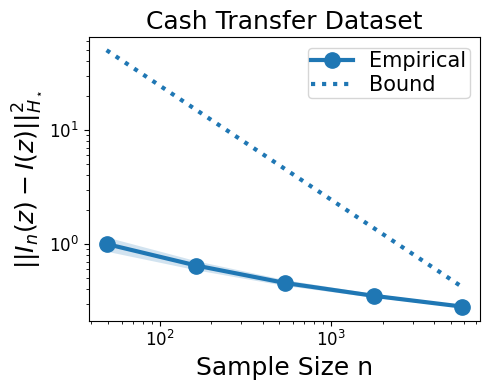

In [12]:
n_ls = [49, 164, 540, 1775, 5835]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
ax.plot(n_ls, mean_diff_abs_total,
        color=COLORS[0], marker=shape[0], markersize=11, label="Empirical")
# Scale the statistical bound by a constant of 50
ax.plot(n_ls, pd.DataFrame(50*stat_bound_ls[0]/np.max(stat_bound_ls[0]))[
        0:5], color=COLORS[0], linestyle=line[1], label="Bound")
ax.fill_between(n_ls, [np.abs(m-sd/np.sqrt(n)).item() for m, sd, n in zip(mean_diff_abs_total, sd_diff_abs_total, n_ls)],
                [np.abs(m+sd/np.sqrt(n)).item() for m, sd, n in zip(mean_diff_abs_total, sd_diff_abs_total, n_ls)], alpha=0.2)
ax.set_ylabel(r'$\|\| I_{n}(z) - I(z) \|\|_{H_\star}^2$')
ax.set_xlabel("Sample Size n")
ax.set_title('Cash Transfer Dataset')
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc='upper right', borderpad=.15, labelspacing=.2)


plt.tight_layout()
